In [223]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [224]:
import os
import numpy as np
import logging

# Configuração do logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def load_embeddings_and_labels(embeddings_dir, expected_embedding_size=128):
    embeddings = []
    labels = []
    augmented_embeddings = []
    augmented_labels = []
    max_frames = 156  # Define o número de frames máximo

    for genre in os.listdir(embeddings_dir):
        genre_path = os.path.join(embeddings_dir, genre)
        if os.path.isdir(genre_path):
            for file_name in os.listdir(genre_path):
                if file_name.endswith("_vggish.npy") or file_name.endswith("_augmented_vggish.npy"):
                    file_path = os.path.join(genre_path, file_name)
                    data = np.load(file_path, allow_pickle=True).item()
                    embedding = data["embeddings"]
                    label = genre

                    # Ajustar o embedding para o tamanho fixo
                    if embedding.shape[0] < max_frames:
                        padded_embedding = np.pad(embedding, ((0, max_frames - embedding.shape[0]), (0, 0)), mode='constant')
                    else:
                        padded_embedding = embedding[:max_frames, :]

                    # Separar os dados originais e os aumentados
                    if "_augmented_vggish.npy" in file_name:
                        augmented_embeddings.append(padded_embedding)
                        augmented_labels.append(label)
                    else:
                        embeddings.append(padded_embedding)
                        labels.append(label)

    if not embeddings:
        raise ValueError("Nenhuma embedding válida encontrada no diretório.")

    embeddings = np.array(embeddings)
    embeddings = embeddings / np.max(np.abs(embeddings))  # Normalizar os dados

    augmented_embeddings = np.array(augmented_embeddings)
    augmented_embeddings = augmented_embeddings / np.max(np.abs(augmented_embeddings))  # Normalizar os dados

    return embeddings, labels, augmented_embeddings, augmented_labels

In [225]:
import os
import numpy as np
import pandas as pd
import logging

# Configuração do logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def load_lyrics_embeddings(embeddings_dir, metadata_csv_path, max_frames=156, batch_size=50):
    """
    Carrega os embeddings de letras em lotes e associa metadados a partir do arquivo CSV fornecido.

    Args:
        embeddings_dir (str): Diretório contendo os arquivos de embeddings.
        metadata_csv_path (str): Caminho para o arquivo CSV com os metadados.
        max_frames (int): Número máximo de frames por embedding.
        batch_size (int): Tamanho do lote para processar os embeddings.

    Returns:
        tuple: (embeddings, labels, songs, artists)
    """
    logging.info("Iniciando o carregamento dos embeddings de letras em lotes.")
    logging.info(f"Diretório de embeddings: {embeddings_dir}")
    logging.info(f"Arquivo de metadados: {metadata_csv_path}")

    # Carregar metadados do CSV
    try:
        metadata_df = pd.read_csv(metadata_csv_path)
        logging.info(f"Metadados carregados com sucesso. Total de registros: {len(metadata_df)}")
    except FileNotFoundError:
        logging.error(f"Arquivo CSV não encontrado: {metadata_csv_path}")
        raise
    except pd.errors.EmptyDataError:
        logging.error(f"Arquivo CSV está vazio: {metadata_csv_path}")
        raise
    except Exception as e:
        logging.error(f"Erro inesperado ao carregar o CSV: {e}")
        raise

    # Criar dicionário de metadados
    metadata_dict = {}
    try:
        metadata_dict = {
            row['filename']: {'song': row['song'], 'artist': row['artist'], 'genre': row['genre'].lower()}
            for _, row in metadata_df.iterrows()
        }
    except KeyError as e:
        logging.error(f"Coluna esperada ausente no CSV: {e}")
        raise
    except Exception as e:
        logging.error(f"Erro ao processar o CSV: {e}")
        raise

    embeddings, labels, songs, artists = [], [], [], []
    try:
        total_files = len([f for f in os.listdir(embeddings_dir) if f.endswith("_embedding.npy")])
        logging.info(f"Total de arquivos de embeddings encontrados: {total_files}")
    except FileNotFoundError:
        logging.error(f"Diretório de embeddings não encontrado: {embeddings_dir}")
        raise
    except Exception as e:
        logging.error(f"Erro ao listar arquivos no diretório: {e}")
        raise

    # Iterar pelos arquivos de embeddings no diretório em lotes
    batch_embeddings, batch_labels, batch_songs, batch_artists = [], [], [], []
    for idx, file_name in enumerate(os.listdir(embeddings_dir)):
        if file_name.endswith("_embedding.npy"):
            file_path = os.path.join(embeddings_dir, file_name)
            try:
                # Carregar o embedding
                embedding = np.load(file_path, allow_pickle=True)
            except FileNotFoundError:
                logging.error(f"Arquivo não encontrado: {file_path}")
                continue
            except ValueError as e:
                logging.error(f"Erro ao carregar o arquivo {file_name}: {e}")
                continue
            except Exception as e:
                logging.error(f"Erro inesperado ao carregar o arquivo {file_name}: {e}")
                continue

            # Ajustar o formato do embedding
            try:
                if embedding.ndim == 1:
                    embedding = np.expand_dims(embedding, axis=0)
                if embedding.shape[0] < max_frames:
                    embedding = np.pad(embedding, ((0, max_frames - embedding.shape[0]), (0, 0)), mode='constant')
                else:
                    embedding = embedding[:max_frames, :]
            except Exception as e:
                logging.error(f"Erro ao ajustar o embedding do arquivo {file_name}: {e}")
                continue

            # Adicionar embedding ao lote
            batch_embeddings.append(embedding)
            if file_name in metadata_dict:
                batch_labels.append(metadata_dict[file_name]['genre'])
                batch_songs.append(metadata_dict[file_name]['song'])
                batch_artists.append(metadata_dict[file_name]['artist'])
                logging.debug(f"Arquivo processado: {file_name} | Gênero: {metadata_dict[file_name]['genre']}")
            else:
                logging.warning(f"Metadados não encontrados para o arquivo {file_name}")

            # Quando o lote atinge o tamanho máximo, processá-lo
            if (len(batch_embeddings) >= batch_size) or (idx + 1 == total_files):
                logging.info(f"Processando lote de {len(batch_embeddings)} arquivos.")

                embeddings.extend(batch_embeddings)
                labels.extend(batch_labels)
                songs.extend(batch_songs)
                artists.extend(batch_artists)

                # Limpar os lotes para liberar memória
                batch_embeddings, batch_labels, batch_songs, batch_artists = [], [], [], []

            # Log de progresso
            if (idx + 1) % 50 == 0 or (idx + 1) == total_files:
                logging.info(f"Processados {idx + 1}/{total_files} arquivos.")
    
            # Logs para verificar o tamanho dos embeddings antes de normalizar
            logging.info(f"Dimensões dos embeddings carregados antes da normalização: {np.shape(embeddings)}")
    if len(embeddings) > 0:
        logging.info(f"Primeiro embedding shape: {embeddings[0].shape}")
        logging.info(f"Tamanho total dos embeddings carregados: {np.sum([e.nbytes for e in embeddings]) / (1024 * 1024):.2f} MB")

    # Converter para numpy array e normalizar
    try:
        embeddings = np.array(embeddings)
        if embeddings.size > 0:
            embeddings /= np.max(np.abs(embeddings))  # Normalizar os embeddings
        else:
            logging.warning("Nenhum embedding foi carregado ou processado.")
    except Exception as e:
        logging.error(f"Erro ao converter embeddings para numpy array: {e}")
        raise

    # Logs para verificar o tamanho dos embeddings após a normalização
    logging.info(f"Dimensões dos embeddings carregados após a normalização: {embeddings.shape}")
    logging.info(f"Tamanho total dos embeddings normalizados: {embeddings.nbytes / (1024 * 1024):.2f} MB")

    logging.info("Carregamento e processamento de embeddings concluído.")
    logging.info(f"Total de embeddings carregados: {len(embeddings)}")
    logging.info(f"Total de gêneros identificados: {len(set(labels))}")

    return embeddings, labels


In [226]:
def balance_samples(X_audio, y_audio, X_lyrics, y_lyrics, target_count=210):
    y_audio_idx = np.argmax(y_audio, axis=1)
    y_lyrics_idx = np.argmax(y_lyrics, axis=1)

    X_audio_balanced, y_audio_balanced = [], []
    for class_idx in np.unique(y_audio_idx):
        class_samples = X_audio[y_audio_idx == class_idx]
        class_labels = y_audio[y_audio_idx == class_idx]
        if len(class_samples) > target_count:
            X_resampled, y_resampled = resample(class_samples, class_labels, n_samples=target_count, random_state=42, replace=False)
        else:
            X_resampled, y_resampled = resample(class_samples, class_labels, n_samples=target_count, random_state=42, replace=True)
        X_audio_balanced.append(X_resampled)
        y_audio_balanced.append(y_resampled)

    X_lyrics_balanced, y_lyrics_balanced = [], []
    for class_idx in np.unique(y_lyrics_idx):
        class_samples = X_lyrics[y_lyrics_idx == class_idx]
        class_labels = y_lyrics[y_lyrics_idx == class_idx]
        if len(class_samples) > target_count:
            X_resampled, y_resampled = resample(class_samples, class_labels, n_samples=target_count, random_state=42, replace=False)
        else:
            X_resampled, y_resampled = resample(class_samples, class_labels, n_samples=target_count, random_state=42, replace=True)
        X_lyrics_balanced.append(X_resampled)
        y_lyrics_balanced.append(y_resampled)

    X_audio_balanced = np.vstack(X_audio_balanced)
    y_audio_balanced = np.vstack(y_audio_balanced)
    X_lyrics_balanced = np.vstack(X_lyrics_balanced)
    y_lyrics_balanced = np.vstack(y_lyrics_balanced)

    return X_audio_balanced, y_audio_balanced, X_lyrics_balanced, y_lyrics_balanced

In [227]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

def create_multimodal_cnn(input_shape_lyrics, input_shape_audio, num_classes):
    # Branch for Lyrics
    lyrics_input = Input(shape=input_shape_lyrics, name="lyrics_input")
    x_lyrics = Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.001))(lyrics_input)
    x_lyrics = BatchNormalization()(x_lyrics)
    x_lyrics = MaxPooling1D(pool_size=2)(x_lyrics)
    x_lyrics = Dropout(0.3)(x_lyrics)
    
    x_lyrics = Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.001))(x_lyrics)
    x_lyrics = BatchNormalization()(x_lyrics)
    x_lyrics = MaxPooling1D(pool_size=2)(x_lyrics)
    x_lyrics = Dropout(0.3)(x_lyrics)
    
    x_lyrics = Conv1D(256, 3, activation='relu', kernel_regularizer=l2(0.001))(x_lyrics)
    x_lyrics = BatchNormalization()(x_lyrics)
    x_lyrics = MaxPooling1D(pool_size=2)(x_lyrics)
    x_lyrics = Dropout(0.4)(x_lyrics)
    
    x_lyrics = Flatten()(x_lyrics)

    # Branch for Audio
    audio_input = Input(shape=input_shape_audio, name="audio_input")
    x_audio = Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.001))(audio_input)
    x_audio = BatchNormalization()(x_audio)
    x_audio = MaxPooling1D(pool_size=2)(x_audio)
    x_audio = Dropout(0.3)(x_audio)
    
    x_audio = Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.001))(x_audio)
    x_audio = BatchNormalization()(x_audio)
    x_audio = MaxPooling1D(pool_size=2)(x_audio)
    x_audio = Dropout(0.3)(x_audio)
    
    x_audio = Conv1D(256, 3, activation='relu', kernel_regularizer=l2(0.001))(x_audio)
    x_audio = BatchNormalization()(x_audio)
    x_audio = MaxPooling1D(pool_size=2)(x_audio)
    x_audio = Dropout(0.4)(x_audio)
    
    x_audio = Flatten()(x_audio)

    # Combine both branches
    combined = concatenate([x_lyrics, x_audio])
    
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(combined)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    
    output = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=[lyrics_input, audio_input], outputs=output)


In [228]:
import logging

# Configuração de logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

audio_embeddings_dir = '/home/jmayos/songtest/songresult_gtzan'
lyrics_embeddings_dir = '/home/jmayos/songtest/embeddings'
metadata_csv_path = '/home/jmayos/songtest/embeddings/metadata.csv'

# Log sobre o início do carregamento das embeddings de letras
logging.info("Iniciando o carregamento dos embeddings de letras...")
lyrics_embeddings, lyrics_labels = load_lyrics_embeddings(lyrics_embeddings_dir, metadata_csv_path)
logging.info(f"Embeddings de letras carregadas: {len(lyrics_embeddings)} exemplos encontrados.")
logging.info(f"Classes únicas em letras: {set(lyrics_labels)}")

2024-12-02 11:45:44,103 - INFO - Iniciando o carregamento dos embeddings de letras...
2024-12-02 11:45:44,105 - INFO - Iniciando o carregamento dos embeddings de letras em lotes.
2024-12-02 11:45:44,107 - INFO - Diretório de embeddings: /home/jmayos/songtest/embeddings
2024-12-02 11:45:44,109 - INFO - Arquivo de metadados: /home/jmayos/songtest/embeddings/metadata.csv
2024-12-02 11:45:44,114 - INFO - Metadados carregados com sucesso. Total de registros: 427
2024-12-02 11:45:44,154 - INFO - Total de arquivos de embeddings encontrados: 210
2024-12-02 11:45:44,159 - INFO - Dimensões dos embeddings carregados antes da normalização: (0,)
2024-12-02 11:45:44,162 - INFO - Dimensões dos embeddings carregados antes da normalização: (0,)
2024-12-02 11:45:44,165 - INFO - Dimensões dos embeddings carregados antes da normalização: (0,)
2024-12-02 11:45:44,167 - INFO - Dimensões dos embeddings carregados antes da normalização: (0,)
2024-12-02 11:45:44,169 - INFO - Dimensões dos embeddings carregados

In [229]:
# Log sobre o início do carregamento das embeddings de áudio
logging.info("Iniciando o carregamento dos embeddings de áudio...")
audio_embeddings, audio_labels, audio_augmented_embeddings, audio_augmented_labels = load_embeddings_and_labels(audio_embeddings_dir)
logging.info(f"Embeddings de áudio carregadas: {len(audio_embeddings)} exemplos originais encontrados.")
logging.info(f"Embeddings de áudio aumentadas: {len(audio_augmented_embeddings)} exemplos encontrados.")
logging.info(f"Classes únicas em áudio: {set(audio_labels)}")

# Combinar embeddings originais e aumentadas
logging.info("Combinando embeddings originais e aumentadas...")
audio_embeddings = np.concatenate([audio_embeddings, audio_augmented_embeddings], axis=0)
audio_labels += audio_augmented_labels
logging.info(f"Total de embeddings de áudio após combinação: {len(audio_embeddings)} exemplos.")

# Verificar gêneros válidos e ajustar rótulos
valid_genres = {'jazz', 'blues', 'metal', 'reggae', 'hiphop', 'pop', 'country', 'classical', 'disco', 'rock'}
audio_labels_mapped = [label if label in valid_genres else 'outros' for label in audio_labels]
logging.info(f"Classes únicas após mapeamento de gêneros inválidos: {set(audio_labels_mapped)}")

logging.info("Carregamento e preparação dos dados concluídos.")


2024-12-02 11:45:44,614 - INFO - Iniciando o carregamento dos embeddings de áudio...
2024-12-02 11:45:45,238 - INFO - Embeddings de áudio carregadas: 999 exemplos originais encontrados.
2024-12-02 11:45:45,239 - INFO - Embeddings de áudio aumentadas: 999 exemplos encontrados.
2024-12-02 11:45:45,240 - INFO - Classes únicas em áudio: {'disco', 'pop', 'rock', 'metal', 'hiphop', 'blues', 'jazz', 'country', 'reggae', 'classical'}
2024-12-02 11:45:45,240 - INFO - Combinando embeddings originais e aumentadas...
2024-12-02 11:45:45,324 - INFO - Total de embeddings de áudio após combinação: 1998 exemplos.
2024-12-02 11:45:45,325 - INFO - Classes únicas após mapeamento de gêneros inválidos: {'disco', 'pop', 'rock', 'metal', 'hiphop', 'blues', 'jazz', 'country', 'reggae', 'classical'}
2024-12-02 11:45:45,326 - INFO - Carregamento e preparação dos dados concluídos.


In [230]:
label_encoder = LabelEncoder()
audio_labels_mapped = label_encoder.fit_transform(audio_labels_mapped)
audio_labels_mapped = to_categorical(audio_labels_mapped)

print(audio_labels_mapped)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [231]:
from sklearn.utils import resample
import numpy as np

def limit_samples_to_exact_count(embeddings, labels, target_count=209):
    """
    Garante exatamente `target_count` exemplos após o balanceamento, por classe.
    """
    classes = np.unique(labels)
    limited_embeddings = []
    limited_labels = []

    # Número de exemplos que cada classe deve contribuir
    examples_per_class = max(1, target_count // len(classes))  # Garante ao menos 1 exemplo por classe

    for cls in classes:
        # Filtrar os exemplos da classe atual
        indices = [i for i, label in enumerate(labels) if label == cls]
        embeddings_cls = [embeddings[i] for i in indices]
        labels_cls = [labels[i] for i in indices]

        # Fazer downsampling ou usar todos os exemplos disponíveis
        if len(embeddings_cls) >= examples_per_class:
            embeddings_resampled, labels_resampled = resample(
                embeddings_cls, labels_cls, replace=False, n_samples=examples_per_class, random_state=42
            )
        else:
            # Fazer upsampling para manter representatividade
            embeddings_resampled, labels_resampled = resample(
                embeddings_cls, labels_cls, replace=True, n_samples=examples_per_class, random_state=42
            )

        # Adicionar ao conjunto balanceado
        limited_embeddings.extend(embeddings_resampled)
        limited_labels.extend(labels_resampled)

    # Ajustar para o número exato de exemplos
    if len(limited_embeddings) > target_count:
        limited_embeddings, limited_labels = resample(
            limited_embeddings, limited_labels, replace=False, n_samples=target_count, random_state=42
        )

    return np.array(limited_embeddings), np.array(limited_labels)


def upsample_samples_to_target(embeddings, labels, target_count=1000):
    """
    Aumenta o número de exemplos para atingir `target_count`, duplicando amostras existentes.
    """
    current_count = len(embeddings)

    if current_count >= target_count:
        return embeddings, labels

    # Calcular número de exemplos adicionais necessários
    additional_count = target_count - current_count

    # Fazer upsampling com reposição
    embeddings_upsampled, labels_upsampled = resample(
        embeddings, labels, replace=True, n_samples=additional_count, random_state=42
    )

    # Concatenar os exemplos originais e os upsampled
    embeddings = np.concatenate([embeddings, embeddings_upsampled])
    labels = np.concatenate([labels, labels_upsampled])

    return embeddings, labels


# Ajustar embeddings de áudio para 1000 exemplos
audio_embeddings, filtered_audio_labels = limit_samples_to_exact_count(audio_embeddings, audio_labels, target_count=1000)

# Atualizar rótulos categorizados de áudio após o ajuste
audio_labels_mapped = label_encoder.fit_transform(filtered_audio_labels)
audio_labels_mapped = to_categorical(audio_labels_mapped)

# Verificar classes após o balanceamento


# Ajustar embeddings de letras para 1000 exemplos
lyrics_embeddings, filtered_lyrics_labels = limit_samples_to_exact_count(lyrics_embeddings, lyrics_labels, target_count=1000)

# Atualizar rótulos categorizados de letras após o ajuste
lyrics_labels_mapped = label_encoder.fit_transform(filtered_lyrics_labels)
lyrics_labels_mapped = to_categorical(lyrics_labels_mapped)

# Verificar classes após o balanceamento de letras
print(f"Classes únicas após downsampling de letras: {np.unique(filtered_lyrics_labels)}")


# Ajustar embeddings de letras para exatamente 1000 exemplos (com upsampling)
lyrics_embeddings, filtered_lyrics_labels = upsample_samples_to_target(lyrics_embeddings, filtered_lyrics_labels, target_count=1000)

# Atualizar rótulos categorizados de letras após o ajuste
lyrics_labels_mapped = label_encoder.fit_transform(filtered_lyrics_labels)
lyrics_labels_mapped = to_categorical(lyrics_labels_mapped)



# Verificar classes após upsampling
print(f"Classes únicas após upsampling de letras: {np.unique(filtered_lyrics_labels)}")


# Logging das informações finais
print(f"Após balanceamento, embeddings de áudio ajustadas para: {len(audio_embeddings)} exemplos")
print(f"Após balanceamento, rótulos de áudio ajustados para: {len(audio_labels_mapped)} exemplos")
print(f"Após balanceamento, embeddings de letras ajustadas para: {len(lyrics_embeddings)} exemplos")
print(f"Após balanceamento, rótulos de letras ajustados para: {len(lyrics_labels_mapped)} exemplos")


Classes únicas após downsampling de letras: ['disco' 'hip hop' 'metal' 'pop' 'reggae' 'rock']
Classes únicas após upsampling de letras: ['disco' 'hip hop' 'metal' 'pop' 'reggae' 'rock']
Após balanceamento, embeddings de áudio ajustadas para: 1000 exemplos
Após balanceamento, rótulos de áudio ajustados para: 1000 exemplos
Após balanceamento, embeddings de letras ajustadas para: 1000 exemplos
Após balanceamento, rótulos de letras ajustados para: 1000 exemplos


In [232]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

# Garantir consistência entre os dados de áudio e letras
if len(audio_embeddings) != len(lyrics_embeddings):
    raise ValueError(
        f"Dados inconsistentes após filtragem: "
        f"audio_embeddings={len(audio_embeddings)}, lyrics_embeddings={len(lyrics_embeddings)}"
    )

# Verificar dimensões iniciais
print(f"Dimensões de audio_embeddings: {audio_embeddings.shape}")
print(f"Dimensões de lyrics_embeddings: {lyrics_embeddings.shape}")
print(f"Dimensões de audio_labels_mapped: {audio_labels_mapped.shape}")

# Ajustar o tamanho de audio_labels_mapped para corresponder ao número de amostras
if len(audio_labels_mapped) != len(audio_embeddings):
    print("Ajustando o tamanho de audio_labels_mapped para corresponder a audio_embeddings.")
    audio_labels_mapped = audio_labels_mapped[:len(audio_embeddings)]

# Verificar dimensões corrigidas
print(f"Dimensões corrigidas de audio_labels_mapped: {audio_labels_mapped.shape}")

# Validar a distribuição das classes nos rótulos
print(f"Distribuição de classes nos rótulos antes da divisão: {np.sum(audio_labels_mapped, axis=0)}")

# Divisão dos dados (com balanceamento usando stratify)
X_train_audio, X_test_audio, X_train_lyrics, X_test_lyrics, y_train, y_test = train_test_split(
    audio_embeddings, lyrics_embeddings, audio_labels_mapped, 
    test_size=0.2, random_state=42, stratify=np.argmax(audio_labels_mapped, axis=1)
)

# Verificar dimensões após a divisão
print(f"Formato do conjunto de treino (áudio): {X_train_audio.shape}")
print(f"Formato do conjunto de treino (letras): {X_train_lyrics.shape}")
print(f"Formato dos rótulos de treino: {y_train.shape}")
print(f"Formato do conjunto de teste (áudio): {X_test_audio.shape}")
print(f"Formato do conjunto de teste (letras): {X_test_lyrics.shape}")
print(f"Formato dos rótulos de teste: {y_test.shape}")

# Validar as classes após divisão
print(f"Classes únicas nos rótulos de treino: {np.unique(np.argmax(y_train, axis=1))}")
print(f"Classes únicas nos rótulos de teste: {np.unique(np.argmax(y_test, axis=1))}")

# Calcular pesos das classes
y_train_classes = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_classes),
    y=y_train_classes
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Exibir os pesos das classes
print(f"Pesos das classes: {class_weight_dict}")

# Configurar formas de entrada e número de classes
input_shape_audio = (X_train_audio.shape[1], X_train_audio.shape[2])
input_shape_lyrics = (X_train_lyrics.shape[1], X_train_lyrics.shape[2])
num_classes = y_train.shape[1]

# Verificações finais
print(f"Input shape (áudio): {input_shape_audio}")
print(f"Input shape (letras): {input_shape_lyrics}")
print(f"Número de classes: {num_classes}")


Dimensões de audio_embeddings: (1000, 156, 128)
Dimensões de lyrics_embeddings: (1000, 156, 128)
Dimensões de audio_labels_mapped: (1000, 10)
Dimensões corrigidas de audio_labels_mapped: (1000, 10)
Distribuição de classes nos rótulos antes da divisão: [100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
Formato do conjunto de treino (áudio): (800, 156, 128)
Formato do conjunto de treino (letras): (800, 156, 128)
Formato dos rótulos de treino: (800, 10)
Formato do conjunto de teste (áudio): (200, 156, 128)
Formato do conjunto de teste (letras): (200, 156, 128)
Formato dos rótulos de teste: (200, 10)
Classes únicas nos rótulos de treino: [0 1 2 3 4 5 6 7 8 9]
Classes únicas nos rótulos de teste: [0 1 2 3 4 5 6 7 8 9]
Pesos das classes: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}
Input shape (áudio): (156, 128)
Input shape (letras): (156, 128)
Número de classes: 10


Epoch 1/100
50/50 [==============================] - 4s 36ms/step - loss: 5.4928 - categorical_accuracy: 0.1025 - precision_12: 0.1192 - recall_12: 0.0637 - val_loss: 3.6417 - val_categorical_accuracy: 0.0900 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00
Epoch 2/100
50/50 [==============================] - 2s 30ms/step - loss: 4.3441 - categorical_accuracy: 0.0875 - precision_12: 0.0625 - recall_12: 0.0113 - val_loss: 3.6289 - val_categorical_accuracy: 0.0800 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00
Epoch 3/100
50/50 [==============================] - 1s 29ms/step - loss: 4.0243 - categorical_accuracy: 0.1187 - precision_12: 0.0862 - recall_12: 0.0063 - val_loss: 3.6200 - val_categorical_accuracy: 0.0800 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00
Epoch 4/100
50/50 [==============================] - 1s 29ms/step - loss: 3.7994 - categorical_accuracy: 0.1363 - precision_12: 0.1429 - recall_12: 0.0037 - val_loss: 3.6114 - val_categorical_accu

2024-12-02 11:48:21,463 - INFO - Classes presentes no conjunto de teste: [0 1 2 3 4 5 6 7 8 9]
2024-12-02 11:48:21,463 - INFO - Classes válidas no conjunto de teste: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


              precision    recall  f1-score   support

       blues       0.95      0.90      0.92        20
   classical       1.00      0.85      0.92        20
     country       0.77      1.00      0.87        20
       disco       0.94      0.80      0.86        20
      hiphop       0.91      1.00      0.95        20
        jazz       1.00      1.00      1.00        20
       metal       1.00      1.00      1.00        20
         pop       1.00      1.00      1.00        20
      reggae       0.94      0.85      0.89        20
        rock       0.86      0.90      0.88        20

    accuracy                           0.93       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.93      0.93       200



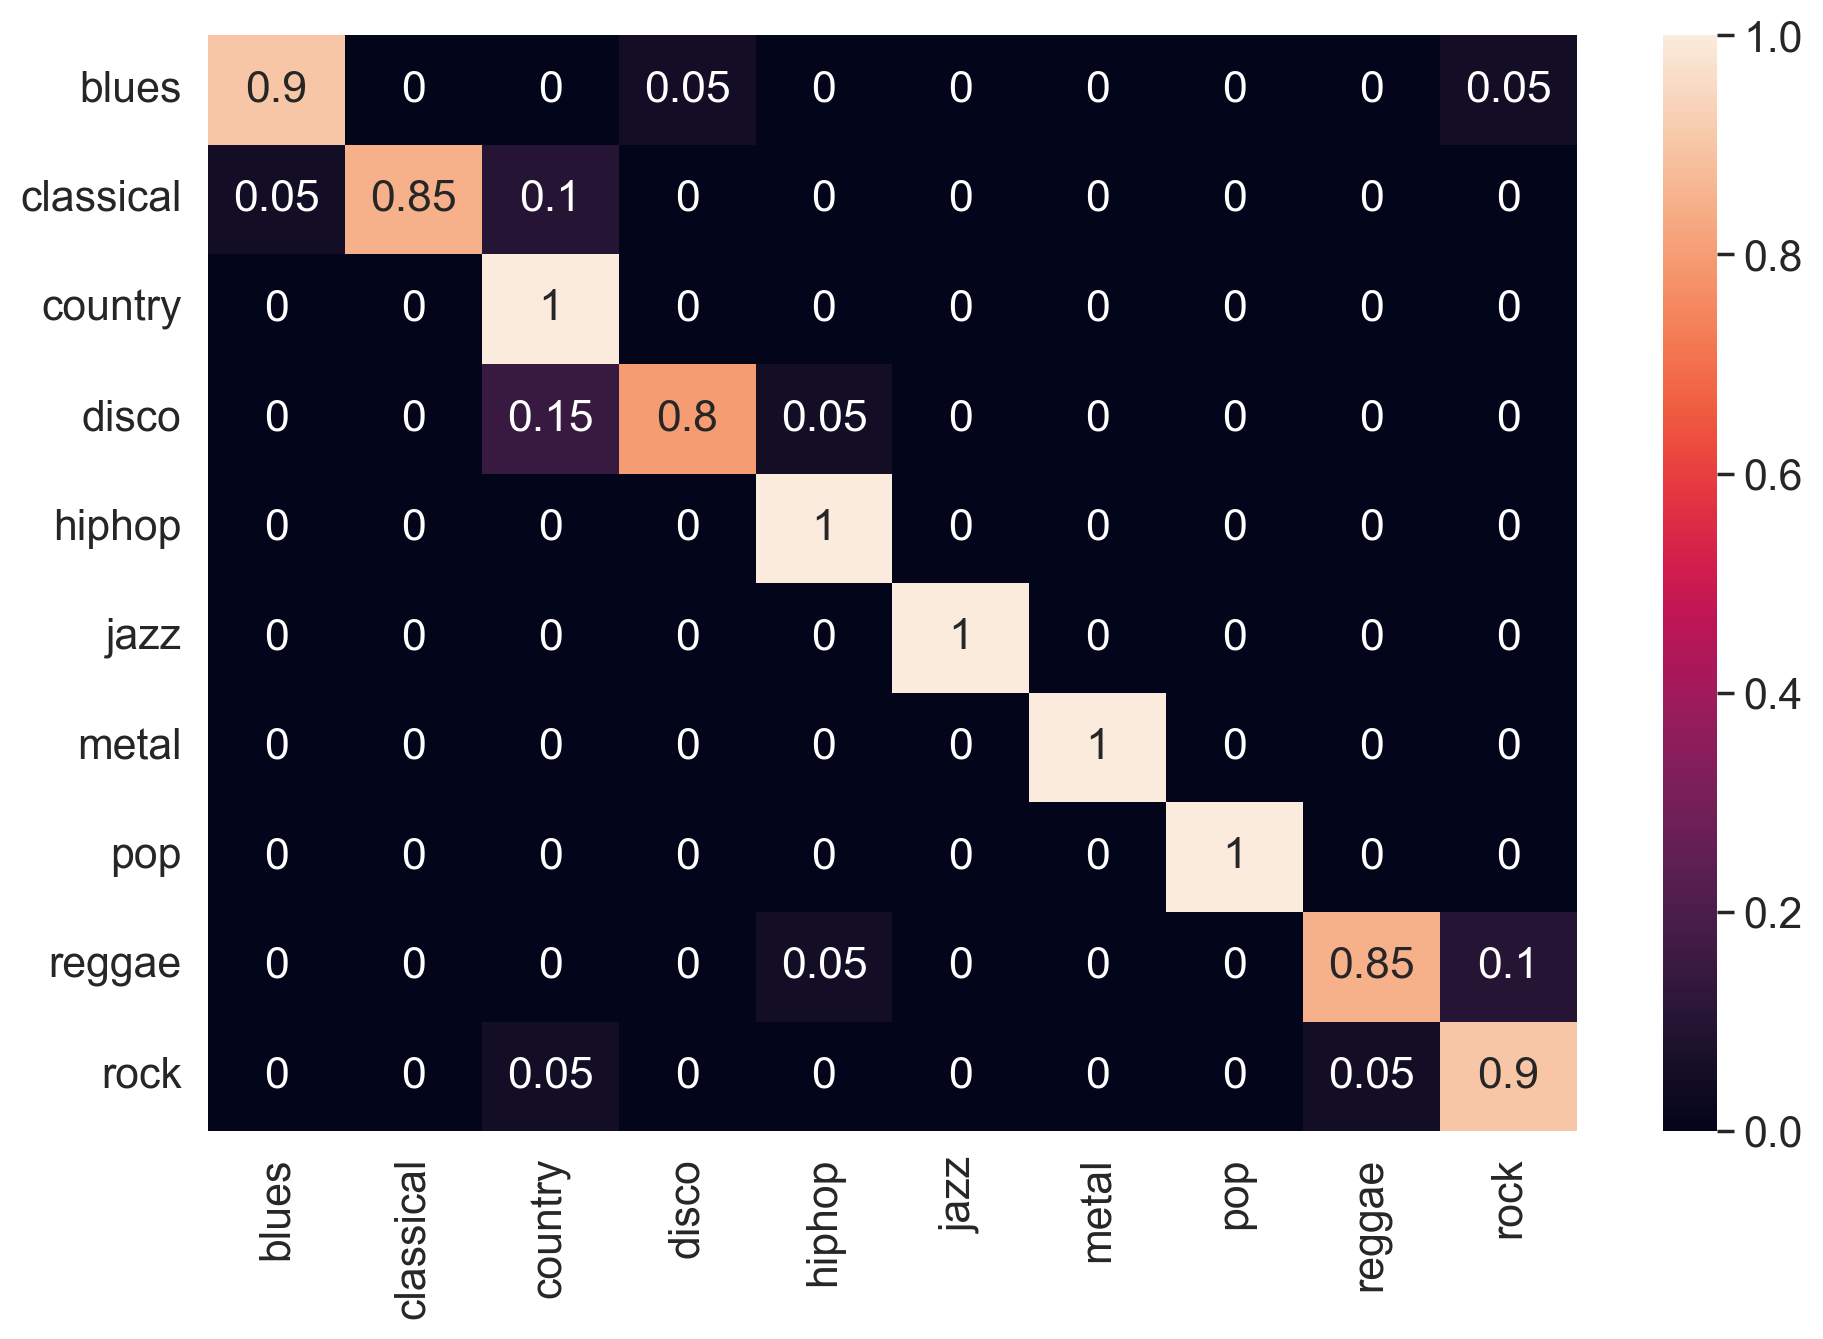

In [233]:
# Criar modelo multimodal
multimodal_model = create_multimodal_cnn(input_shape_lyrics, input_shape_audio, num_classes)

# Compilar o modelo
multimodal_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[CategoricalAccuracy(), Precision(), Recall()]
)

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinar o modelo
history = multimodal_model.fit(
    [X_train_lyrics, X_train_audio], y_train,
    epochs=100, batch_size=16,
    validation_data=([X_test_lyrics, X_test_audio], y_test),
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

# Avaliação do modelo
loss, accuracy, precision, recall = multimodal_model.evaluate([X_test_lyrics, X_test_audio], y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

# Ajustar o LabelEncoder para incluir todas as classes esperadas
all_possible_classes = ['jazz', 'blues', 'metal', 'reggae', 'hiphop', 'pop', 'country', 'classical', 'disco', 'rock']
label_encoder = LabelEncoder()
label_encoder.fit(all_possible_classes)

# Verificar as classes codificadas no `LabelEncoder`
print("Classes mapeadas no LabelEncoder:", label_encoder.classes_)

# Geração de previsões
y_pred = np.argmax(multimodal_model.predict([X_test_lyrics, X_test_audio]), axis=1)
y_true = np.argmax(y_test, axis=1)

# Garantir consistência entre classes de treinamento e teste
classes_in_test = np.unique(y_true)
logging.info(f"Classes presentes no conjunto de teste: {classes_in_test}")

# Verificar classes que estão fora do escopo do LabelEncoder
unknown_classes = set(classes_in_test) - set(range(len(label_encoder.classes_)))
if unknown_classes:
    logging.warning(f"Classes desconhecidas no teste: {unknown_classes}")

# Garantir que todas as classes em `classes_in_test` estão no LabelEncoder
valid_classes_in_test = [cls for cls in classes_in_test if cls in range(len(label_encoder.classes_))]
logging.info(f"Classes válidas no conjunto de teste: {valid_classes_in_test}")

# Mapear classes válidas de volta para os gêneros
target_names = label_encoder.inverse_transform(valid_classes_in_test)

# Garantir que `target_names` seja uma lista de strings
target_names = [str(name) for name in target_names]

# Relatório de classificação
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

# Criar matriz de confusão
class_names = label_encoder.classes_
conf_mat = confusion_matrix(y_true, y_pred, normalize='true')
conf_mat = np.round(conf_mat, 2)

# Criar DataFrame para a matriz de confusão
conf_mat_df = pd.DataFrame(conf_mat, columns=target_names, index=target_names)

# Plotar matriz de confusão
# Plotar matriz de confusão normalizada
plt.figure(figsize = (10,7), dpi = 200)
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()

# Salvar matriz de confusão
plt.savefig(os.getcwd() + "/multimodal_confusion_matrix_with_labels.png")
plt.show()
